In [1]:
# necessary imports
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.primitives import Sampler, Estimator

from squlearn.feature_map import YZ_CX_FeatureMap, QiskitZFeatureMap
from squlearn.kernel.matrix import FidelityKernel
from squlearn.kernel.matrix import ProjectedQuantumKernel
from squlearn.kernel.ml import QGPR
from generate_training_data_xsinx import generate_points

In [2]:
# load quantum instance options
statevec = Aer.get_backend('statevector_simulator')
backend = Aer.get_backend('qasm_simulator')
QI_qasm = QuantumInstance(backend,shots=5000)
QI_statevec = QuantumInstance(statevec)
sampler = Sampler()
estimator = Estimator()

In [3]:
import matplotlib.pyplot as plt
# Generate training data.
training_start= np.pi * 0
training_end = np.pi * 2
noise_variance = 0.2
training_data = generate_points(
    training_start, training_end, section=7, quota=[2, 5], noise=noise_variance)
X, Y = training_data
# Setup testing locations.
# You can change the testing locations here.
X_test = np.linspace(training_start, training_end + 0*np.pi, 50)
func = X_test * np.sin(X_test)
print(np.array([X.reshape(-1,1).ravel() for _ in range(4)])) 

[[0.         0.8975979  0.8975979  1.12199738 1.34639685 1.57079633
  1.7951958  1.7951958  2.6927937  2.6927937  2.91719318 3.14159265
  3.36599213 3.5903916  3.5903916  4.48798951 4.48798951 4.71238898
  4.93678846 5.16118793 5.38558741 5.38558741 6.28318531]
 [0.         0.8975979  0.8975979  1.12199738 1.34639685 1.57079633
  1.7951958  1.7951958  2.6927937  2.6927937  2.91719318 3.14159265
  3.36599213 3.5903916  3.5903916  4.48798951 4.48798951 4.71238898
  4.93678846 5.16118793 5.38558741 5.38558741 6.28318531]
 [0.         0.8975979  0.8975979  1.12199738 1.34639685 1.57079633
  1.7951958  1.7951958  2.6927937  2.6927937  2.91719318 3.14159265
  3.36599213 3.5903916  3.5903916  4.48798951 4.48798951 4.71238898
  4.93678846 5.16118793 5.38558741 5.38558741 6.28318531]
 [0.         0.8975979  0.8975979  1.12199738 1.34639685 1.57079633
  1.7951958  1.7951958  2.6927937  2.6927937  2.91719318 3.14159265
  3.36599213 3.5903916  3.5903916  4.48798951 4.48798951 4.71238898
  4.936788

In [4]:
# set up quantum kernel and qgpr
num_qubits = 4
fmap = YZ_CX_FeatureMap(
    num_qubits,num_features=num_qubits,num_layers=2,c=1.0)
np.random.seed(0)
param = np.random.rand(fmap.num_parameters)
q_kernel = FidelityKernel(
    feature_map=fmap,quantum_instance=statevec)
q_kernel.assign_parameters(param)
qgpr_ansatz = QGPR(
    quantum_kernel=q_kernel, sigma=noise_variance**2)

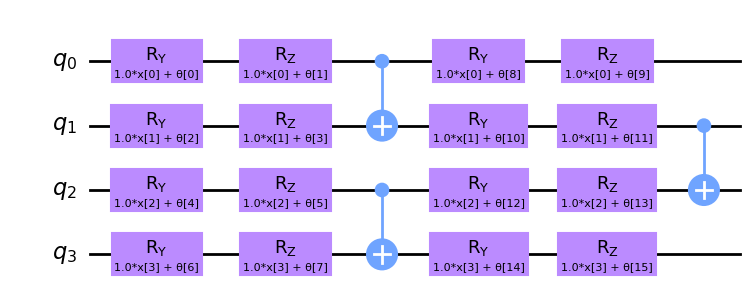

In [5]:
fmap.draw()

In [6]:
pqk_kernel = ProjectedQuantumKernel(
      pqk_hyper_param=2.0,
      feature_map=fmap,
      quantum_instance=QI_statevec
)
pqk_kernel.assign_parameters(param)
qgpr_ansatz_pqk = QGPR(
    quantum_kernel=pqk_kernel, sigma=noise_variance**2)

In [7]:
print(pqk_kernel.num_features)

4


In [8]:
pqk_kernel_estimator = ProjectedQuantumKernel(
      pqk_hyper_param=2.0,
      feature_map=fmap,
      primitive=estimator
)
pqk_kernel_estimator.assign_parameters(param)
qgpr_ansatz_pqk_estimator = QGPR(
    quantum_kernel=pqk_kernel_estimator, sigma=noise_variance**2)

In [9]:
pqk_kernel_sampler = ProjectedQuantumKernel(
      pqk_hyper_param=2.0,
      feature_map=fmap,
      primitive=sampler
)
pqk_kernel_sampler.assign_parameters(param)
qgpr_ansatz_pqk_sampler = QGPR(
    quantum_kernel=pqk_kernel_sampler, sigma=noise_variance**2, regularize='full')

In [10]:
#perform qgpr
qgpr_ansatz.fit(X_train=X.reshape(-1,1), y_train=Y)


Regularizing full Gram matrix


QGPR(quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x000002411A3D70A0>,
     sigma=0.04000000000000001)

In [11]:
qgpr_mean, qgpr_std = qgpr_ansatz.predict(
    X_test=X_test.reshape(-1,1)
)

Regularizing full Gram matrix
Reconstruction error -2.313104541891084e-13


In [11]:
print(X.shape)

(23,)


In [12]:
#perform qgpr with PQK + QuantumInstance
qgpr_ansatz_pqk.fit(X_train=X.reshape(-1,1), y_train=Y)
qgpr_mean_pqk, qgpr_std_pqk = qgpr_ansatz_pqk.predict(
    X_test=X_test.reshape(-1,1)
)

In [13]:
#perform qgpr with PQK + Estimator
qgpr_ansatz_pqk_estimator.fit(X_train=X.reshape(-1,1), y_train=Y)
qgpr_mean_pqk_estimator, qgpr_std_pqk_estimator = qgpr_ansatz_pqk_estimator.predict(
    X_test=X_test.reshape(-1,1)
)

running job on ibmq backend with job id:  41bd7947-5c17-4e37-b094-16ae899f11ce
running job on ibmq backend with job id:  96d2597d-14cc-4919-94be-211e39dc0520
running job on ibmq backend with job id:  50771f78-0c0c-4f89-b348-62aefa66b7da
running job on ibmq backend with job id:  deeb1004-cc5c-4962-88c6-948fd18a1439


In [14]:
#perform qgpr with PQK + Sampler
qgpr_ansatz_pqk_sampler.fit(X_train=X.reshape(-1,1), y_train=Y)
qgpr_mean_pqk_sampler, qgpr_std_pqk_sampler = qgpr_ansatz_pqk_sampler.predict(
    X_test=X_test.reshape(-1,1)
)

Text(0, 0.5, '$f(x)$')

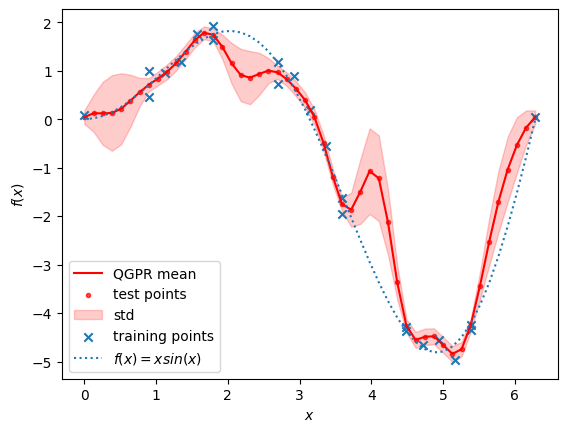

In [12]:
# plot result
plt.plot(X_test.reshape(-1,1), qgpr_mean, color='red', label='QGPR mean')
plt.scatter(X_test.reshape(-1,1), qgpr_mean, marker='.',
label='test points', color='red', alpha=0.7)
plt.fill_between(X_test.reshape(-1),
                 qgpr_mean.reshape(-1) -  qgpr_std,
                 qgpr_mean.reshape(-1) + qgpr_std,
                 color='red',label='std', alpha=0.2)
marker_size = 50
plt.scatter(X, Y, marker='x', label='training points')
plt.plot(X_test, func, label=r"$f(x) = x sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

Text(0, 0.5, '$f(x)$')

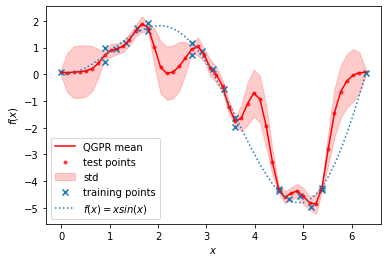

In [16]:
# plot PQK results with QuantumInstance
plt.plot(X_test.reshape(-1,1), qgpr_mean_pqk, color='red', label='QGPR mean')
plt.scatter(X_test.reshape(-1,1), qgpr_mean_pqk, marker='.',
label='test points', color='red', alpha=0.7)
plt.fill_between(X_test.reshape(-1),
                 qgpr_mean_pqk.reshape(-1) -  qgpr_std_pqk,
                 qgpr_mean_pqk.reshape(-1) + qgpr_std_pqk,
                 color='red',label='std', alpha=0.2)
marker_size = 50
plt.scatter(X, Y, marker='x', label='training points')
plt.plot(X_test, func, label=r"$f(x) = x sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

Text(0, 0.5, '$f(x)$')

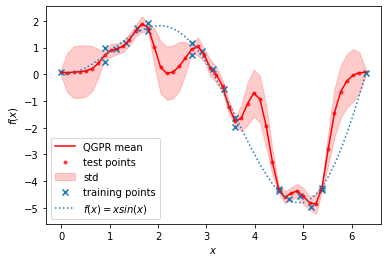

In [17]:
# plot PQK results with ESTIMATOR
plt.plot(X_test.reshape(-1,1), qgpr_mean_pqk_estimator, color='red', label='QGPR mean')
plt.scatter(X_test.reshape(-1,1), qgpr_mean_pqk_estimator, marker='.',
label='test points', color='red', alpha=0.7)
plt.fill_between(X_test.reshape(-1),
                 qgpr_mean_pqk_estimator.reshape(-1) -  qgpr_std_pqk_estimator,
                 qgpr_mean_pqk_estimator.reshape(-1) + qgpr_std_pqk_estimator,
                 color='red',label='std', alpha=0.2)
marker_size = 50
plt.scatter(X, Y, marker='x', label='training points')
plt.plot(X_test, func, label=r"$f(x) = x sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

Text(0, 0.5, '$f(x)$')

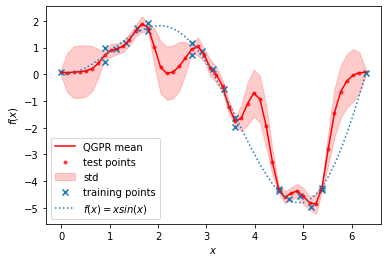

In [18]:
# plot PQK results with Sampler
plt.plot(X_test.reshape(-1,1), qgpr_mean_pqk_sampler, color='red', label='QGPR mean')
plt.scatter(X_test.reshape(-1,1), qgpr_mean_pqk_sampler, marker='.',
label='test points', color='red', alpha=0.7)
plt.fill_between(X_test.reshape(-1),
                 qgpr_mean_pqk_sampler.reshape(-1) -  qgpr_std_pqk_sampler,
                 qgpr_mean_pqk_sampler.reshape(-1) + qgpr_std_pqk_sampler,
                 color='red',label='std', alpha=0.2)
marker_size = 50
plt.scatter(X, Y, marker='x', label='training points')
plt.plot(X_test, func, label=r"$f(x) = x sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

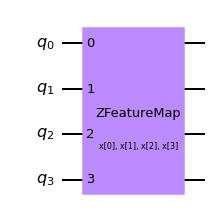

In [19]:
# Testing if wrapper for Qiskit's ZFeatureMap works
fmap_qiskit_zfeature = QiskitZFeatureMap(num_qubits=4, num_features=4)
fmap_qiskit_zfeature.draw('mpl')

In [20]:
pqk_kernel_estimator_zfeaturemap = ProjectedQuantumKernel(
      pqk_hyper_param=2.0,
      feature_map=fmap_qiskit_zfeature,
      primitive=estimator
)
#pqk_kernel_estimator.assign_parameters(param)
qgpr_ansatz_pqk_estimator_zfeaturemap = QGPR(
    quantum_kernel=pqk_kernel_estimator_zfeaturemap, sigma=noise_variance**2)

In [21]:
#perform qgpr with PQK + Estimator with Qiskit's ZFeatureMap
qgpr_ansatz_pqk_estimator_zfeaturemap.fit(X_train=X.reshape(-1,1), y_train=Y)
qgpr_mean_pqk_estimator_zfeaturemap, qgpr_std_pqk_estimator_zfeaturemap = qgpr_ansatz_pqk_estimator_zfeaturemap.predict(
    X_test=X_test.reshape(-1,1)
)

running job on ibmq backend with job id:  26ecb6c5-c64f-477b-b772-1dc7ddbef555
running job on ibmq backend with job id:  5e86cc48-b86b-4db6-b7ab-385d25d0d3df
running job on ibmq backend with job id:  992de9dd-f763-46de-b3d0-4365ea909a98
running job on ibmq backend with job id:  492afe60-ba59-406f-a54b-63e9a6290a78


Text(0, 0.5, '$f(x)$')

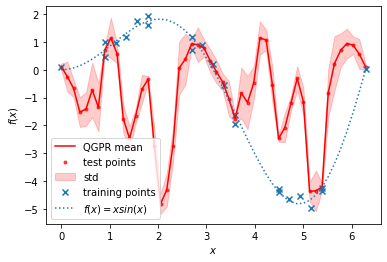

In [22]:
# plot PQK results with ESTIMATOR + Qiskit's ZFeaturemap
plt.plot(X_test.reshape(-1,1), qgpr_mean_pqk_estimator_zfeaturemap, color='red', label='QGPR mean')
plt.scatter(X_test.reshape(-1,1), qgpr_mean_pqk_estimator_zfeaturemap, marker='.',
label='test points', color='red', alpha=0.7)
plt.fill_between(X_test.reshape(-1),
                 qgpr_mean_pqk_estimator_zfeaturemap.reshape(-1) -  qgpr_std_pqk_estimator_zfeaturemap,
                 qgpr_mean_pqk_estimator_zfeaturemap.reshape(-1) + qgpr_std_pqk_estimator_zfeaturemap,
                 color='red',label='std', alpha=0.2)
marker_size = 50
plt.scatter(X, Y, marker='x', label='training points')
plt.plot(X_test, func, label=r"$f(x) = x sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")